In [4]:
!pip install -r requirements.txt

In [1]:
!nvidia-smi

Mon Mar 30 03:57:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
! unzip starter_set.zip

Archive:  starter_set.zip
replace starter_set/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
import numpy as np
import os
import png
import torch
from tqdm import tqdm
from torch.utils.data.dataset import Dataset
from PIL import Image

class FacadeDataset(Dataset):
    def __init__(self, flag, dataDir='./starter_set/', data_range=(0, 8), n_class=5, onehot=False):
        self.onehot = onehot
        assert(flag in ['train', 'eval', 'test', 'test_dev', 'kaggle'])
        print("load "+ flag+" dataset start")
        print("    from: %s" % dataDir)
        print("    range: [%d, %d)" % (data_range[0], data_range[1]))
        self.dataset = []
        for i in range(data_range[0], data_range[1]):
            img = Image.open(os.path.join(dataDir,flag,'eecs442_%04d.jpg' % i))

            pngreader = png.Reader(filename=os.path.join(dataDir,flag,'eecs442_%04d.png' % i))
            w,h,row,info = pngreader.read()
            label = np.array(list(row)).astype('uint8')

            # Normalize input image
            img = np.asarray(img).astype("f").transpose(2, 0, 1)/128.0-1.0
            # Convert to n_class-dimensional onehot matrix
            label_ = np.asarray(label)
            label = np.zeros((n_class, img.shape[1], img.shape[2])).astype("i")
            for j in range(n_class):
                label[j, :] = label_ == j
            self.dataset.append((img, label))
        print("load dataset done")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, label = self.dataset[index]
        label = torch.FloatTensor(label)
        if not self.onehot:
            label = torch.argmax(label, dim=0)
        else:
            label = label.long()

        return torch.FloatTensor(img), torch.LongTensor(label)


In [0]:
import os
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import png
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from colormap.colors import Color, hex2rgb
from sklearn.metrics import average_precision_score as ap_score
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from tqdm import tqdm

# from dataset import FacadeDataset

N_CLASS=5

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.n_class = N_CLASS
        self.layers = nn.Sequential(
            #########################################
            ###        TODO: Add more layers      ###
            nn.Conv2d(3, 64, 5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # nn.Conv2d(256, 128, 3, padding=1),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(2, 2),

            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ConvTranspose2d(64, 16, 4, stride=2, padding=1),
            nn.Conv2d(16, self.n_class, 1, padding=0)

            #########################################
            #nn.Conv2d(3, self.n_class, 1, padding=0)
            # nn.ReLU(inplace=True)
            )

    def forward(self, x):
        x = self.layers(x)
        return x


def save_label(label, path):
    '''
    Function for ploting labels.
    '''
    colormap = [
        '#000000',
        '#0080FF',
        '#80FF80',
        '#FF8000',
        '#FF0000',
    ]
    assert(np.max(label)<len(colormap))
    colors = [hex2rgb(color, normalise=False) for color in colormap]
    w = png.Writer(label.shape[1], label.shape[0], palette=colors, bitdepth=4)
    with open(path, 'wb') as f:
        w.write(f, label)

def train(trainloader, net, criterion, optimizer, device, epoch):
    '''
    Function for training.
    '''
    start = time.time()
    running_loss = 0.0
    net = net.train()

    losses = 0.
    cnt = 0
    for images, labels in tqdm(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = net(images)
        #print(output.detach().cpu().numpy().shape)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss = loss.item()
        losses += running_loss
        cnt += 1
    end = time.time()
    print('[epoch %d] loss: %.3f average_losses: %.3f elapsed time %.3f' %
          (epoch, running_loss, losses / cnt, end-start))
    return losses / cnt

def test(testloader, net, criterion, device):
    '''
    Function for testing.
    '''
    losses = 0.
    cnt = 0
    with torch.no_grad():
        net = net.eval()
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)
            #print(output.detach().cpu().numpy().shape)
            loss = criterion(output, labels)
            losses += loss.item()
            cnt += 1
    print(losses / cnt)
    return (losses/cnt)


def cal_AP(testloader, net, criterion, device):
    '''
    Calculate Average Precision
    '''
    losses = 0.
    cnt = 0
    with torch.no_grad():
        net = net.eval()
        preds = [[] for _ in range(5)]
        heatmaps = [[] for _ in range(5)]
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images).cpu().numpy()
            for c in range(5):
                preds[c].append(output[:, c].reshape(-1))
                heatmaps[c].append(labels[:, c].cpu().numpy().reshape(-1))

        aps = []
        for c in range(5):
            preds[c] = np.concatenate(preds[c])
            heatmaps[c] = np.concatenate(heatmaps[c])
            if heatmaps[c].max() == 0:
                ap = float('nan')
            else:
                ap = ap_score(heatmaps[c], preds[c])
                aps.append(ap)
            print("AP = {}".format(ap))
        average_ap = np.mean(aps)
        print("Average Ap = {}".format(average_ap))

    # print(losses / cnt)
    return None


def get_result(testloader, net, device, folder='output_train'):
    result = []
    cnt = 1
    with torch.no_grad():
        net = net.eval()
        cnt = 0
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)[0].cpu().numpy()
            c, h, w = output.shape
            assert(c == N_CLASS)
            y = np.zeros((h,w)).astype('uint8')
            for i in range(N_CLASS):
                mask = output[i]>0.5
                y[mask] = i
            gt = labels.cpu().data.numpy().squeeze(0).astype('uint8')
            save_label(y, './{}/y{}.png'.format(folder, cnt))
            save_label(gt, './{}/gt{}.png'.format(folder, cnt))
            plt.imsave(
                './{}/x{}.png'.format(folder, cnt),
                ((images[0].cpu().data.numpy()+1)*128).astype(np.uint8).transpose(1,2,0))

            cnt += 1
            
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]
 
def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ', device)
# TODO change data_range to include all train/evaluation/test data.
# TODO adjust batch_size.
train_data = FacadeDataset(flag='train', data_range=(0, 768), onehot=False)
print(train_data.__len__())
train_loader = DataLoader(train_data, batch_size=16)

val_data = FacadeDataset(flag='train', data_range=(768,896), onehot=False)
print(val_data.__len__())
val_loader = DataLoader(train_data, batch_size=32)

test_data = FacadeDataset(flag='test_dev', data_range=(0,114), onehot=False)
test_loader = DataLoader(test_data, batch_size=1)
ap_data = FacadeDataset(flag='test_dev', data_range=(0,114), onehot=True)
ap_loader = DataLoader(ap_data, batch_size=1)


device:  cuda:0
load train dataset start
    from: ./starter_set/
    range: [0, 768)
load dataset done
768
load train dataset start
    from: ./starter_set/
    range: [768, 896)
load dataset done
128
load test_dev dataset start
    from: ./starter_set/
    range: [0, 114)
load dataset done
load test_dev dataset start
    from: ./starter_set/
    range: [0, 114)
load dataset done


In [15]:
lr = 1e-3
name = '6layerfcn_lr1e-3'
net = Net().to(device)
criterion = nn.CrossEntropyLoss() #TODO decide loss
optimizer = torch.optim.Adam(net.parameters(), lr, weight_decay=1e-3)

print('\nStart training')
train_history = []
val_history = []
for epoch in range(40): #TODO decide epochs
    print('-----------------Epoch = %d-----------------' % (epoch+1))
    trainloss = train(train_loader, net, criterion, optimizer, device, epoch+1)
    # TODO create your evaluation set, load the evaluation set and test on evaluation set
    val_loss = test(val_loader, net, criterion, device)

    train_history.append(trainloss)
    val_history.append(val_loss)


Start training
-----------------Epoch = 1-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:22,  2.12it/s]

  4%|▍         | 2/48 [00:00<00:20,  2.22it/s]

  6%|▋         | 3/48 [00:01<00:19,  2.29it/s]

  8%|▊         | 4/48 [00:01<00:18,  2.34it/s]

 10%|█         | 5/48 [00:02<00:18,  2.37it/s]

 12%|█▎        | 6/48 [00:02<00:17,  2.40it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.42it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.45it/s]

 19%|█▉        | 9/48 [00:03<00:16,  2.43it/s]

 21%|██        | 10/48 [00:04<00:15,  2.45it/s]

 23%|██▎       | 11/48 [00:04<00:15,  2.46it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.43it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.43it/s]

 29%|██▉       | 14/48 [00:05<00:14,  2.42it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.45it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.46it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.47it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.47it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.45it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 1] loss: 1.349 average_losses: 1.349 elapsed time 19.554




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.60it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.61it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.61it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.61it/s]

 21%|██        | 5/24 [00:03<00:11,  1.61it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.61it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.62it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.61it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.59it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.60it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.59it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.60it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.60it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.61it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.61it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.61it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.61it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.59it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

1.2745158225297928
-----------------Epoch = 2-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:20,  2.35it/s]

  4%|▍         | 2/48 [00:00<00:19,  2.36it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.40it/s]

  8%|▊         | 4/48 [00:01<00:18,  2.41it/s]

 10%|█         | 5/48 [00:02<00:17,  2.43it/s]

 12%|█▎        | 6/48 [00:02<00:17,  2.43it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.42it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.43it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.44it/s]

 21%|██        | 10/48 [00:04<00:15,  2.45it/s]

 23%|██▎       | 11/48 [00:04<00:15,  2.44it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.44it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.44it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.44it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.46it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.47it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.46it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.48it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.44it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 2] loss: 1.295 average_losses: 1.253 elapsed time 19.614




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.60it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.61it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.60it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.61it/s]

 21%|██        | 5/24 [00:03<00:11,  1.61it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.61it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.61it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.61it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.61it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.61it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.60it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.58it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.59it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.59it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.60it/s]

 67%|██████▋   | 16/24 [00:09<00:05,  1.59it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.60it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.59it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.60it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

1.2222191244363785
-----------------Epoch = 3-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.47it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.48it/s]

  6%|▋         | 3/48 [00:01<00:17,  2.50it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.50it/s]

 10%|█         | 5/48 [00:02<00:17,  2.49it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.49it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.50it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.48it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.49it/s]

 21%|██        | 10/48 [00:04<00:15,  2.48it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.48it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.49it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.49it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.49it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.48it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.48it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.49it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.47it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.48it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 3] loss: 1.215 average_losses: 1.216 elapsed time 19.400




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.62it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.61it/s]

 12%|█▎        | 3/24 [00:01<00:12,  1.62it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.61it/s]

 21%|██        | 5/24 [00:03<00:11,  1.59it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.60it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.60it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.61it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.60it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.59it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.59it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.59it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.59it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.59it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.58it/s]

 67%|██████▋   | 16/24 [00:10<00:05,  1.59it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.60it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.59it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.60it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

1.175700639684995
-----------------Epoch = 4-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.38it/s]

  4%|▍         | 2/48 [00:00<00:19,  2.42it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.43it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.45it/s]

 10%|█         | 5/48 [00:02<00:17,  2.46it/s]

 12%|█▎        | 6/48 [00:02<00:17,  2.44it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.47it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.47it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.48it/s]

 21%|██        | 10/48 [00:04<00:15,  2.49it/s]

 23%|██▎       | 11/48 [00:04<00:15,  2.47it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.48it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.49it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.45it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.48it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.46it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.48it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.49it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.49it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 4] loss: 1.110 average_losses: 1.156 elapsed time 19.421




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.59it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.58it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.57it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.57it/s]

 21%|██        | 5/24 [00:03<00:12,  1.58it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.59it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.58it/s]

 33%|███▎      | 8/24 [00:05<00:10,  1.59it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.59it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.58it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.59it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.59it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.60it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.59it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.58it/s]

 67%|██████▋   | 16/24 [00:10<00:05,  1.56it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.56it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.57it/s]

 79%|███████▉  | 19/24 [00:12<00:03,  1.58it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

1.0770628154277802
-----------------Epoch = 5-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:20,  2.29it/s]

  4%|▍         | 2/48 [00:00<00:19,  2.33it/s]

  6%|▋         | 3/48 [00:01<00:19,  2.34it/s]

  8%|▊         | 4/48 [00:01<00:18,  2.38it/s]

 10%|█         | 5/48 [00:02<00:17,  2.42it/s]

 12%|█▎        | 6/48 [00:02<00:17,  2.41it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.43it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.44it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.45it/s]

 21%|██        | 10/48 [00:04<00:15,  2.47it/s]

 23%|██▎       | 11/48 [00:04<00:15,  2.45it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.46it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.46it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.47it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.47it/s]

 33%|███▎      | 16/48 [00:06<00:13,  2.45it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.46it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.48it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.48it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 5] loss: 1.030 average_losses: 1.035 elapsed time 19.464




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.62it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.62it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.61it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.60it/s]

 21%|██        | 5/24 [00:03<00:11,  1.60it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.60it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.60it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.61it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.61it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.60it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.60it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.60it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.61it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.61it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.61it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.60it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.60it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.58it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.9796605755885442
-----------------Epoch = 6-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:18,  2.48it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.47it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.48it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.49it/s]

 10%|█         | 5/48 [00:02<00:17,  2.48it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.48it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.48it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.49it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.51it/s]

 21%|██        | 10/48 [00:04<00:15,  2.51it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.51it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.49it/s]

 27%|██▋       | 13/48 [00:05<00:13,  2.51it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.51it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.50it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.50it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.48it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.49it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.50it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 6] loss: 0.990 average_losses: 0.969 elapsed time 19.376




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.60it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.60it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.59it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.60it/s]

 21%|██        | 5/24 [00:03<00:11,  1.59it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.60it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.61it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.61it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.60it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.59it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.59it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.58it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.58it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.59it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.60it/s]

 67%|██████▋   | 16/24 [00:10<00:05,  1.60it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.59it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.59it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.60it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.9471030260125796
-----------------Epoch = 7-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.44it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.47it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.46it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.47it/s]

 10%|█         | 5/48 [00:02<00:17,  2.46it/s]

 12%|█▎        | 6/48 [00:02<00:17,  2.47it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.47it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.46it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.46it/s]

 21%|██        | 10/48 [00:04<00:15,  2.43it/s]

 23%|██▎       | 11/48 [00:04<00:15,  2.43it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.44it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.42it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.43it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.44it/s]

 33%|███▎      | 16/48 [00:06<00:13,  2.45it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.46it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.46it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.42it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 7] loss: 0.963 average_losses: 0.935 elapsed time 19.494




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:13,  1.65it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.64it/s]

 12%|█▎        | 3/24 [00:01<00:12,  1.62it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.63it/s]

 21%|██        | 5/24 [00:03<00:11,  1.61it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.62it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.61it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.61it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.62it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.61it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.61it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.60it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.60it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.61it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.59it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.61it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.59it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.59it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.59it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.9243084490299225
-----------------Epoch = 8-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:21,  2.22it/s]

  4%|▍         | 2/48 [00:00<00:20,  2.28it/s]

  6%|▋         | 3/48 [00:01<00:19,  2.33it/s]

  8%|▊         | 4/48 [00:01<00:18,  2.38it/s]

 10%|█         | 5/48 [00:02<00:17,  2.43it/s]

 12%|█▎        | 6/48 [00:02<00:17,  2.43it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.44it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.42it/s]

 19%|█▉        | 9/48 [00:03<00:16,  2.42it/s]

 21%|██        | 10/48 [00:04<00:15,  2.45it/s]

 23%|██▎       | 11/48 [00:04<00:15,  2.44it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.47it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.47it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.48it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.48it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.47it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.47it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.49it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.50it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 8] loss: 0.951 average_losses: 0.915 elapsed time 19.449




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.57it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.58it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.58it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.58it/s]

 21%|██        | 5/24 [00:03<00:11,  1.59it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.60it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.59it/s]

 33%|███▎      | 8/24 [00:05<00:09,  1.60it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.60it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.61it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.61it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.60it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.60it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.61it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.61it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.59it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.60it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.60it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.8971871212124825
-----------------Epoch = 9-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.46it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.46it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.47it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.47it/s]

 10%|█         | 5/48 [00:02<00:17,  2.48it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.48it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.49it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.49it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.46it/s]

 21%|██        | 10/48 [00:04<00:15,  2.48it/s]

 23%|██▎       | 11/48 [00:04<00:15,  2.46it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.48it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.48it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.48it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.45it/s]

 33%|███▎      | 16/48 [00:06<00:13,  2.46it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.46it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.44it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.44it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 9] loss: 0.930 average_losses: 0.894 elapsed time 19.492




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.58it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.60it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.60it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.60it/s]

 21%|██        | 5/24 [00:03<00:11,  1.60it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.60it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.60it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.60it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.59it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.59it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.60it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.60it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.60it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.59it/s]

 67%|██████▋   | 16/24 [00:10<00:05,  1.60it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.60it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.61it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.61it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.8817898432413737
-----------------Epoch = 10-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:18,  2.50it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.48it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.49it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.46it/s]

 10%|█         | 5/48 [00:02<00:17,  2.48it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.48it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.48it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.49it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.45it/s]

 21%|██        | 10/48 [00:04<00:15,  2.47it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.48it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.43it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.45it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.47it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.47it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.48it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.48it/s]

 38%|███▊      | 18/48 [00:07<00:11,  2.50it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.46it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 10] loss: 0.901 average_losses: 0.878 elapsed time 19.398




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.61it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.60it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.60it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.60it/s]

 21%|██        | 5/24 [00:03<00:11,  1.60it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.60it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.60it/s]

 33%|███▎      | 8/24 [00:05<00:10,  1.58it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.59it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.59it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.57it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.58it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.59it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.60it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.60it/s]

 67%|██████▋   | 16/24 [00:10<00:05,  1.59it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.59it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.60it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.61it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.8687911530335745
-----------------Epoch = 11-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:18,  2.49it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.49it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.50it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.49it/s]

 10%|█         | 5/48 [00:02<00:17,  2.50it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.51it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.52it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.49it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.49it/s]

 21%|██        | 10/48 [00:03<00:15,  2.50it/s]

 23%|██▎       | 11/48 [00:04<00:15,  2.46it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.47it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.48it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.49it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.49it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.49it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.50it/s]

 38%|███▊      | 18/48 [00:07<00:11,  2.50it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.50it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 11] loss: 0.886 average_losses: 0.860 elapsed time 19.260




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.54it/s]

  8%|▊         | 2/24 [00:01<00:14,  1.55it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.57it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.57it/s]

 21%|██        | 5/24 [00:03<00:11,  1.59it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.59it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.59it/s]

 33%|███▎      | 8/24 [00:05<00:09,  1.60it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.60it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.61it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.61it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.61it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.60it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.60it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.61it/s]

 67%|██████▋   | 16/24 [00:10<00:04,  1.60it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.61it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.62it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.61it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.864052285750707
-----------------Epoch = 12-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:18,  2.50it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.49it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.50it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.50it/s]

 10%|█         | 5/48 [00:01<00:17,  2.51it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.51it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.50it/s]

 17%|█▋        | 8/48 [00:03<00:15,  2.50it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.51it/s]

 21%|██        | 10/48 [00:03<00:15,  2.52it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.52it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.49it/s]

 27%|██▋       | 13/48 [00:05<00:13,  2.50it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.50it/s]

 31%|███▏      | 15/48 [00:05<00:13,  2.51it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.51it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.49it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.50it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.50it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 12] loss: 0.894 average_losses: 0.851 elapsed time 19.287




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:13,  1.64it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.63it/s]

 12%|█▎        | 3/24 [00:01<00:12,  1.63it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.63it/s]

 21%|██        | 5/24 [00:03<00:11,  1.62it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.61it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.62it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.62it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.62it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.62it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.62it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.62it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.62it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.62it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.62it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.61it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.62it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.60it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.61it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.8493681574861208
-----------------Epoch = 13-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.45it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.47it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.47it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.49it/s]

 10%|█         | 5/48 [00:02<00:17,  2.48it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.47it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.49it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.49it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.49it/s]

 21%|██        | 10/48 [00:04<00:15,  2.50it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.49it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.50it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.50it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.50it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.49it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.49it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.51it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.49it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.49it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 13] loss: 0.886 average_losses: 0.843 elapsed time 19.277




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.60it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.61it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.61it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.62it/s]

 21%|██        | 5/24 [00:03<00:11,  1.62it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.62it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.63it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.63it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.62it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.62it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.60it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.61it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.62it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.62it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.62it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.62it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.62it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.59it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.60it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.8459227358301481
-----------------Epoch = 14-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.43it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.43it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.45it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.46it/s]

 10%|█         | 5/48 [00:02<00:17,  2.46it/s]

 12%|█▎        | 6/48 [00:02<00:17,  2.46it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.47it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.48it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.49it/s]

 21%|██        | 10/48 [00:04<00:15,  2.46it/s]

 23%|██▎       | 11/48 [00:04<00:15,  2.45it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.46it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.45it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.47it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.46it/s]

 33%|███▎      | 16/48 [00:06<00:13,  2.43it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.45it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.41it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.43it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 14] loss: 0.876 average_losses: 0.834 elapsed time 19.730




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.59it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.60it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.59it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.60it/s]

 21%|██        | 5/24 [00:03<00:11,  1.61it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.60it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.60it/s]

 33%|███▎      | 8/24 [00:05<00:10,  1.60it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.60it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.60it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.60it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.60it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.60it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.60it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.60it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.60it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.61it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.61it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.60it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.8237098529934883
-----------------Epoch = 15-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.45it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.46it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.47it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.47it/s]

 10%|█         | 5/48 [00:02<00:17,  2.44it/s]

 12%|█▎        | 6/48 [00:02<00:17,  2.45it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.44it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.46it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.47it/s]

 21%|██        | 10/48 [00:04<00:15,  2.46it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.47it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.48it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.46it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.44it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.43it/s]

 33%|███▎      | 16/48 [00:06<00:13,  2.44it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.45it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.46it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.47it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 15] loss: 0.872 average_losses: 0.823 elapsed time 19.500




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.59it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.59it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.59it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.60it/s]

 21%|██        | 5/24 [00:03<00:11,  1.60it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.60it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.60it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.60it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.61it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.61it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.60it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.61it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.61it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.62it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.61it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.62it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.61it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.61it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.825216310719649
-----------------Epoch = 16-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.39it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.42it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.43it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.46it/s]

 10%|█         | 5/48 [00:02<00:17,  2.47it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.47it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.48it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.47it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.48it/s]

 21%|██        | 10/48 [00:04<00:15,  2.49it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.47it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.48it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.49it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.50it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.50it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.48it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.49it/s]

 38%|███▊      | 18/48 [00:07<00:11,  2.50it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.50it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 16] loss: 0.864 average_losses: 0.816 elapsed time 19.378




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.61it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.62it/s]

 12%|█▎        | 3/24 [00:01<00:12,  1.62it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.62it/s]

 21%|██        | 5/24 [00:03<00:11,  1.62it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.61it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.61it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.62it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.60it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.60it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.60it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.60it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.60it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.58it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.59it/s]

 67%|██████▋   | 16/24 [00:09<00:05,  1.60it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.60it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.60it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.60it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.820244754354159
-----------------Epoch = 17-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.47it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.46it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.46it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.47it/s]

 10%|█         | 5/48 [00:02<00:17,  2.47it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.48it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.48it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.47it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.48it/s]

 21%|██        | 10/48 [00:04<00:15,  2.49it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.50it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.49it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.50it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.51it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.50it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.50it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.49it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.48it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.49it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 17] loss: 0.868 average_losses: 0.815 elapsed time 19.334




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.62it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.60it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.60it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.61it/s]

 21%|██        | 5/24 [00:03<00:11,  1.61it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.61it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.62it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.61it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.61it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.61it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.59it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.61it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.62it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.60it/s]

 67%|██████▋   | 16/24 [00:09<00:05,  1.60it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.61it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.61it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.61it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.8080033188064893
-----------------Epoch = 18-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.41it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.45it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.44it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.47it/s]

 10%|█         | 5/48 [00:02<00:17,  2.49it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.49it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.49it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.47it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.49it/s]

 21%|██        | 10/48 [00:04<00:15,  2.46it/s]

 23%|██▎       | 11/48 [00:04<00:15,  2.46it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.47it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.47it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.49it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.50it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.48it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.49it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.49it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.50it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 18] loss: 0.844 average_losses: 0.812 elapsed time 19.346




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.58it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.58it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.60it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.60it/s]

 21%|██        | 5/24 [00:03<00:11,  1.60it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.60it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.60it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.61it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.61it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.61it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.62it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.60it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.60it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.61it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.61it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.61it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.61it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.61it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.7948067088921865
-----------------Epoch = 19-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:18,  2.50it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.49it/s]

  6%|▋         | 3/48 [00:01<00:17,  2.50it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.52it/s]

 10%|█         | 5/48 [00:01<00:17,  2.52it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.51it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.50it/s]

 17%|█▋        | 8/48 [00:03<00:15,  2.51it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.52it/s]

 21%|██        | 10/48 [00:03<00:15,  2.52it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.51it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.51it/s]

 27%|██▋       | 13/48 [00:05<00:13,  2.51it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.52it/s]

 31%|███▏      | 15/48 [00:05<00:13,  2.51it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.51it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.52it/s]

 38%|███▊      | 18/48 [00:07<00:11,  2.52it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.51it/s]

 42%|████▏     | 20/48 [00:07<00:11,

[epoch 19] loss: 0.840 average_losses: 0.802 elapsed time 19.188




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.64it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.62it/s]

 12%|█▎        | 3/24 [00:01<00:12,  1.63it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.63it/s]

 21%|██        | 5/24 [00:03<00:11,  1.63it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.61it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.61it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.62it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.61it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.61it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.62it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.62it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.62it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.62it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.62it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.60it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.61it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.61it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.7960955599943796
-----------------Epoch = 20-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.46it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.47it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.49it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.49it/s]

 10%|█         | 5/48 [00:02<00:17,  2.49it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.50it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.50it/s]

 17%|█▋        | 8/48 [00:03<00:15,  2.51it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.50it/s]

 21%|██        | 10/48 [00:03<00:15,  2.51it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.52it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.51it/s]

 27%|██▋       | 13/48 [00:05<00:13,  2.52it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.48it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.48it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.50it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.50it/s]

 38%|███▊      | 18/48 [00:07<00:11,  2.51it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.48it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 20] loss: 0.818 average_losses: 0.796 elapsed time 19.210




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.57it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.60it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.60it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.61it/s]

 21%|██        | 5/24 [00:03<00:11,  1.61it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.61it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.62it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.62it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.62it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.63it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.60it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.62it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.63it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.63it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.62it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.62it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.62it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.63it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.7766029859582583
-----------------Epoch = 21-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:18,  2.49it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.49it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.48it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.49it/s]

 10%|█         | 5/48 [00:02<00:17,  2.49it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.49it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.49it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.48it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.45it/s]

 21%|██        | 10/48 [00:04<00:15,  2.44it/s]

 23%|██▎       | 11/48 [00:04<00:15,  2.46it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.48it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.46it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.47it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.47it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.49it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.49it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.44it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.45it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 21] loss: 0.820 average_losses: 0.786 elapsed time 19.338




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.63it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.61it/s]

 12%|█▎        | 3/24 [00:01<00:12,  1.62it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.60it/s]

 21%|██        | 5/24 [00:03<00:11,  1.61it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.61it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.61it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.62it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.62it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.62it/s]

 46%|████▌     | 11/24 [00:06<00:07,  1.63it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.63it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.63it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.62it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.63it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.63it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.63it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.63it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.63it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.7761692429582278
-----------------Epoch = 22-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:18,  2.50it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.50it/s]

  6%|▋         | 3/48 [00:01<00:17,  2.51it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.52it/s]

 10%|█         | 5/48 [00:01<00:17,  2.53it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.51it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.50it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.47it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.50it/s]

 21%|██        | 10/48 [00:03<00:15,  2.50it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.49it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.49it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.49it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.50it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.50it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.49it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.50it/s]

 38%|███▊      | 18/48 [00:07<00:11,  2.51it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.52it/s]

 42%|████▏     | 20/48 [00:07<00:11,

[epoch 22] loss: 0.815 average_losses: 0.784 elapsed time 19.208




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.63it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.62it/s]

 12%|█▎        | 3/24 [00:01<00:12,  1.63it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.63it/s]

 21%|██        | 5/24 [00:03<00:11,  1.63it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.62it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.62it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.63it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.63it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.63it/s]

 46%|████▌     | 11/24 [00:06<00:07,  1.63it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.62it/s]

 54%|█████▍    | 13/24 [00:07<00:06,  1.63it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.63it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.63it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.63it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.60it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.61it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.61it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.7632608115673065
-----------------Epoch = 23-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.43it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.44it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.45it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.46it/s]

 10%|█         | 5/48 [00:02<00:17,  2.47it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.48it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.48it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.50it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.48it/s]

 21%|██        | 10/48 [00:04<00:15,  2.48it/s]

 23%|██▎       | 11/48 [00:04<00:15,  2.47it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.48it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.49it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.47it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.47it/s]

 33%|███▎      | 16/48 [00:06<00:13,  2.46it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.47it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.47it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.46it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 23] loss: 0.805 average_losses: 0.777 elapsed time 19.384




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.59it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.60it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.60it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.60it/s]

 21%|██        | 5/24 [00:03<00:11,  1.61it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.61it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.62it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.62it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.61it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.61it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.60it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.61it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.62it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.62it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.62it/s]

 67%|██████▋   | 16/24 [00:09<00:05,  1.59it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.61it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.62it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.62it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.7559636409084002
-----------------Epoch = 24-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:18,  2.49it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.48it/s]

  6%|▋         | 3/48 [00:01<00:17,  2.50it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.51it/s]

 10%|█         | 5/48 [00:02<00:17,  2.48it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.49it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.49it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.50it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.50it/s]

 21%|██        | 10/48 [00:04<00:15,  2.49it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.52it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.51it/s]

 27%|██▋       | 13/48 [00:05<00:13,  2.50it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.51it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.49it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.50it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.50it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.49it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.50it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 24] loss: 0.797 average_losses: 0.769 elapsed time 19.212




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:13,  1.65it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.64it/s]

 12%|█▎        | 3/24 [00:01<00:12,  1.63it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.62it/s]

 21%|██        | 5/24 [00:03<00:11,  1.63it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.62it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.63it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.62it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.60it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.60it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.61it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.61it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.61it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.62it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.62it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.61it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.62it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.62it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.7532733480135599
-----------------Epoch = 25-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:18,  2.52it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.53it/s]

  6%|▋         | 3/48 [00:01<00:17,  2.52it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.51it/s]

 10%|█         | 5/48 [00:01<00:17,  2.52it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.52it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.51it/s]

 17%|█▋        | 8/48 [00:03<00:15,  2.51it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.53it/s]

 21%|██        | 10/48 [00:03<00:15,  2.51it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.51it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.49it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.46it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.48it/s]

 31%|███▏      | 15/48 [00:05<00:13,  2.50it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.51it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.50it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.50it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.50it/s]

 42%|████▏     | 20/48 [00:07<00:11,

[epoch 25] loss: 0.792 average_losses: 0.767 elapsed time 19.234




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.64it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.63it/s]

 12%|█▎        | 3/24 [00:01<00:12,  1.62it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.63it/s]

 21%|██        | 5/24 [00:03<00:11,  1.62it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.62it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.61it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.61it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.61it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.61it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.61it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.62it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.60it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.59it/s]

 67%|██████▋   | 16/24 [00:09<00:05,  1.59it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.60it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.60it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.61it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.7503244529167811
-----------------Epoch = 26-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:18,  2.50it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.47it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.46it/s]

  8%|▊         | 4/48 [00:02<00:23,  1.87it/s]

 10%|█         | 5/48 [00:02<00:22,  1.89it/s]

 12%|█▎        | 6/48 [00:02<00:20,  2.04it/s]

 15%|█▍        | 7/48 [00:03<00:19,  2.15it/s]

 17%|█▋        | 8/48 [00:03<00:17,  2.25it/s]

 19%|█▉        | 9/48 [00:04<00:16,  2.33it/s]

 21%|██        | 10/48 [00:04<00:15,  2.38it/s]

 23%|██▎       | 11/48 [00:04<00:15,  2.41it/s]

 25%|██▌       | 12/48 [00:05<00:14,  2.42it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.44it/s]

 29%|██▉       | 14/48 [00:06<00:13,  2.45it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.46it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.49it/s]

 35%|███▌      | 17/48 [00:07<00:12,  2.47it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.49it/s]

 40%|███▉      | 19/48 [00:08<00:11,  2.50it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 26] loss: 0.785 average_losses: 0.762 elapsed time 19.945




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.57it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.58it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.58it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.59it/s]

 21%|██        | 5/24 [00:03<00:11,  1.59it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.58it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.60it/s]

 33%|███▎      | 8/24 [00:05<00:10,  1.60it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.60it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.61it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.61it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.62it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.59it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.60it/s]

 67%|██████▋   | 16/24 [00:10<00:05,  1.59it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.60it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.59it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.59it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.7413102487723032
-----------------Epoch = 27-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.43it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.45it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.46it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.47it/s]

 10%|█         | 5/48 [00:02<00:17,  2.47it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.48it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.47it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.47it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.49it/s]

 21%|██        | 10/48 [00:04<00:15,  2.48it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.48it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.49it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.47it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.50it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.48it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.48it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.47it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.45it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.47it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 27] loss: 0.782 average_losses: 0.756 elapsed time 19.395




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.57it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.58it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.59it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.59it/s]

 21%|██        | 5/24 [00:03<00:11,  1.59it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.60it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.60it/s]

 33%|███▎      | 8/24 [00:05<00:10,  1.60it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.60it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.60it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.59it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.60it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.60it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.61it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.60it/s]

 67%|██████▋   | 16/24 [00:10<00:05,  1.60it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.60it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.59it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.59it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.742765262722969
-----------------Epoch = 28-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.38it/s]

  4%|▍         | 2/48 [00:00<00:19,  2.41it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.43it/s]

  8%|▊         | 4/48 [00:01<00:18,  2.44it/s]

 10%|█         | 5/48 [00:02<00:17,  2.46it/s]

 12%|█▎        | 6/48 [00:02<00:17,  2.46it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.46it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.47it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.44it/s]

 21%|██        | 10/48 [00:04<00:15,  2.45it/s]

 23%|██▎       | 11/48 [00:04<00:15,  2.45it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.46it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.47it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.47it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.47it/s]

 33%|███▎      | 16/48 [00:06<00:13,  2.46it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.45it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.45it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.46it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 28] loss: 0.777 average_losses: 0.751 elapsed time 19.483




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.58it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.59it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.58it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.59it/s]

 21%|██        | 5/24 [00:03<00:11,  1.60it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.60it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.60it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.61it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.60it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.61it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.61it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.61it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.61it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.61it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.61it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.60it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.61it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.61it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.7405193621913592
-----------------Epoch = 29-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.43it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.42it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.44it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.45it/s]

 10%|█         | 5/48 [00:02<00:17,  2.44it/s]

 12%|█▎        | 6/48 [00:02<00:17,  2.45it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.43it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.45it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.46it/s]

 21%|██        | 10/48 [00:04<00:15,  2.47it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.48it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.46it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.48it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.49it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.50it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.50it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.47it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.49it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.49it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 29] loss: 0.778 average_losses: 0.746 elapsed time 19.433




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.57it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.59it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.59it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.60it/s]

 21%|██        | 5/24 [00:03<00:11,  1.60it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.60it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.61it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.61it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.61it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.62it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.60it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.61it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.62it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.62it/s]

 67%|██████▋   | 16/24 [00:09<00:05,  1.59it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.59it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.60it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.60it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.7315104057391485
-----------------Epoch = 30-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.39it/s]

  4%|▍         | 2/48 [00:00<00:19,  2.40it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.44it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.46it/s]

 10%|█         | 5/48 [00:02<00:17,  2.46it/s]

 12%|█▎        | 6/48 [00:02<00:17,  2.47it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.48it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.46it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.47it/s]

 21%|██        | 10/48 [00:04<00:15,  2.47it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.47it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.48it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.47it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.46it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.48it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.48it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.48it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.47it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.48it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 30] loss: 0.764 average_losses: 0.740 elapsed time 19.445




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.59it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.60it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.60it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.61it/s]

 21%|██        | 5/24 [00:03<00:11,  1.61it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.60it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.59it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.60it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.60it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.61it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.61it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.60it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.59it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.59it/s]

 67%|██████▋   | 16/24 [00:10<00:05,  1.59it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.59it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.59it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.60it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.7279099822044373
-----------------Epoch = 31-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.43it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.44it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.47it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.48it/s]

 10%|█         | 5/48 [00:02<00:17,  2.49it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.49it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.48it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.48it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.49it/s]

 21%|██        | 10/48 [00:04<00:15,  2.49it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.48it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.48it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.49it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.48it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.48it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.47it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.47it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.47it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.47it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 31] loss: 0.757 average_losses: 0.737 elapsed time 19.331




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.56it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.58it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.59it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.59it/s]

 21%|██        | 5/24 [00:03<00:11,  1.60it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.59it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.59it/s]

 33%|███▎      | 8/24 [00:05<00:10,  1.59it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.59it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.60it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.59it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.60it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.60it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.60it/s]

 67%|██████▋   | 16/24 [00:10<00:05,  1.59it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.60it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.61it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.59it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.7244909505049387
-----------------Epoch = 32-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:18,  2.54it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.49it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.48it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.49it/s]

 10%|█         | 5/48 [00:02<00:17,  2.46it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.48it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.42it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.43it/s]

 19%|█▉        | 9/48 [00:03<00:16,  2.39it/s]

 21%|██        | 10/48 [00:04<00:15,  2.41it/s]

 23%|██▎       | 11/48 [00:04<00:15,  2.43it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.43it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.45it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.45it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.45it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.46it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.43it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.45it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.46it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 32] loss: 0.760 average_losses: 0.727 elapsed time 19.574




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.55it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.58it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.59it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.60it/s]

 21%|██        | 5/24 [00:03<00:11,  1.60it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.59it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.59it/s]

 33%|███▎      | 8/24 [00:05<00:10,  1.59it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.59it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.59it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.59it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.59it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.59it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.58it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.58it/s]

 67%|██████▋   | 16/24 [00:10<00:05,  1.59it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.59it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.59it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.59it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.7149125412106514
-----------------Epoch = 33-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.41it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.43it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.45it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.46it/s]

 10%|█         | 5/48 [00:02<00:17,  2.46it/s]

 12%|█▎        | 6/48 [00:02<00:17,  2.45it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.46it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.46it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.46it/s]

 21%|██        | 10/48 [00:04<00:15,  2.47it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.47it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.48it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.49it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.49it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.48it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.49it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.48it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.48it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.47it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 33] loss: 0.752 average_losses: 0.729 elapsed time 19.424




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.61it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.59it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.60it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.59it/s]

 21%|██        | 5/24 [00:03<00:11,  1.59it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.60it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.60it/s]

 33%|███▎      | 8/24 [00:05<00:09,  1.60it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.61it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.60it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.61it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.60it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.60it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.59it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.59it/s]

 67%|██████▋   | 16/24 [00:10<00:05,  1.58it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.59it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.59it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.60it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.7159829313556353
-----------------Epoch = 34-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.42it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.45it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.46it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.47it/s]

 10%|█         | 5/48 [00:02<00:17,  2.49it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.51it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.50it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.50it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.50it/s]

 21%|██        | 10/48 [00:04<00:15,  2.51it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.50it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.50it/s]

 27%|██▋       | 13/48 [00:05<00:13,  2.50it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.48it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.46it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.47it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.46it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.46it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.47it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 34] loss: 0.745 average_losses: 0.722 elapsed time 19.257




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.58it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.59it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.60it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.59it/s]

 21%|██        | 5/24 [00:03<00:11,  1.60it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.59it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.58it/s]

 33%|███▎      | 8/24 [00:05<00:10,  1.59it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.58it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.60it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.61it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.61it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.61it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.62it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.61it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.60it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.61it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.61it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.7107362424333891
-----------------Epoch = 35-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.44it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.43it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.46it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.47it/s]

 10%|█         | 5/48 [00:02<00:17,  2.48it/s]

 12%|█▎        | 6/48 [00:02<00:17,  2.45it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.44it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.46it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.46it/s]

 21%|██        | 10/48 [00:04<00:15,  2.48it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.49it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.47it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.48it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.46it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.44it/s]

 33%|███▎      | 16/48 [00:06<00:13,  2.46it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.45it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.47it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.46it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 35] loss: 0.732 average_losses: 0.720 elapsed time 19.410




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.59it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.59it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.59it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.60it/s]

 21%|██        | 5/24 [00:03<00:11,  1.61it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.60it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.62it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.62it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.62it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.62it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.61it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.62it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.62it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.62it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.62it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.62it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.62it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.62it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.62it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.706609862546126
-----------------Epoch = 36-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:18,  2.50it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.49it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.49it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.45it/s]

 10%|█         | 5/48 [00:02<00:17,  2.45it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.48it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.48it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.48it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.50it/s]

 21%|██        | 10/48 [00:04<00:15,  2.50it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.50it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.50it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.48it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.50it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.52it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.51it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.50it/s]

 38%|███▊      | 18/48 [00:07<00:11,  2.51it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.52it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 36] loss: 0.727 average_losses: 0.717 elapsed time 19.268




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.61it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.62it/s]

 12%|█▎        | 3/24 [00:01<00:12,  1.62it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.61it/s]

 21%|██        | 5/24 [00:03<00:11,  1.61it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.61it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.62it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.62it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.62it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.62it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.62it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.62it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.62it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.62it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.61it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.61it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.61it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.61it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.60it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.7040561884641647
-----------------Epoch = 37-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.44it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.46it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.48it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.47it/s]

 10%|█         | 5/48 [00:02<00:17,  2.48it/s]

 12%|█▎        | 6/48 [00:02<00:17,  2.47it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.48it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.50it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.50it/s]

 21%|██        | 10/48 [00:04<00:15,  2.50it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.50it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.47it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.49it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.51it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.49it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.50it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.50it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.49it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.48it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 37] loss: 0.713 average_losses: 0.710 elapsed time 19.351




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.61it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.61it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.60it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.61it/s]

 21%|██        | 5/24 [00:03<00:11,  1.60it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.61it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.61it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.61it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.61it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.61it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.62it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.62it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.60it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.60it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.60it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.61it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.61it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.61it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.62it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.6993665024638176
-----------------Epoch = 38-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.38it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.42it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.46it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.48it/s]

 10%|█         | 5/48 [00:01<00:17,  2.50it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.49it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.50it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.50it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.52it/s]

 21%|██        | 10/48 [00:03<00:15,  2.52it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.49it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.51it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.49it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.50it/s]

 31%|███▏      | 15/48 [00:05<00:13,  2.51it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.49it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.50it/s]

 38%|███▊      | 18/48 [00:07<00:11,  2.51it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.44it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 38] loss: 0.708 average_losses: 0.708 elapsed time 19.249




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.56it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.57it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.58it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.59it/s]

 21%|██        | 5/24 [00:03<00:11,  1.60it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.60it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.59it/s]

 33%|███▎      | 8/24 [00:05<00:09,  1.60it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.61it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.60it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.60it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.60it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.61it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.61it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.61it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.61it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.60it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.61it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.694960410396258
-----------------Epoch = 39-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.41it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.44it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.47it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.49it/s]

 10%|█         | 5/48 [00:02<00:17,  2.49it/s]

 12%|█▎        | 6/48 [00:02<00:17,  2.47it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.48it/s]

 17%|█▋        | 8/48 [00:03<00:15,  2.50it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.47it/s]

 21%|██        | 10/48 [00:04<00:15,  2.46it/s]

 23%|██▎       | 11/48 [00:04<00:15,  2.46it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.48it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.50it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.50it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.49it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.49it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.49it/s]

 38%|███▊      | 18/48 [00:07<00:11,  2.51it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.50it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 39] loss: 0.713 average_losses: 0.703 elapsed time 19.285




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.61it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.61it/s]

 12%|█▎        | 3/24 [00:01<00:12,  1.62it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.62it/s]

 21%|██        | 5/24 [00:03<00:11,  1.61it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.62it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.62it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.62it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.61it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.61it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.61it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.61it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.61it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.61it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.62it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.61it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.61it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.62it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.6925193692247072
-----------------Epoch = 40-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.42it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.45it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.46it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.47it/s]

 10%|█         | 5/48 [00:02<00:17,  2.49it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.48it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.49it/s]

 17%|█▋        | 8/48 [00:03<00:15,  2.51it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.50it/s]

 21%|██        | 10/48 [00:04<00:15,  2.50it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.49it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.50it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.50it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.49it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.51it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.52it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.50it/s]

 38%|███▊      | 18/48 [00:07<00:11,  2.51it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.51it/s]

 42%|████▏     | 20/48 [00:07<00:11,

[epoch 40] loss: 0.700 average_losses: 0.702 elapsed time 19.216




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.56it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.58it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.59it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.60it/s]

 21%|██        | 5/24 [00:03<00:11,  1.59it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.60it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.61it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.61it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.62it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.62it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.62it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.63it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.62it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.63it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.62it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.61it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.62it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.61it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.61it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.6894555787245432


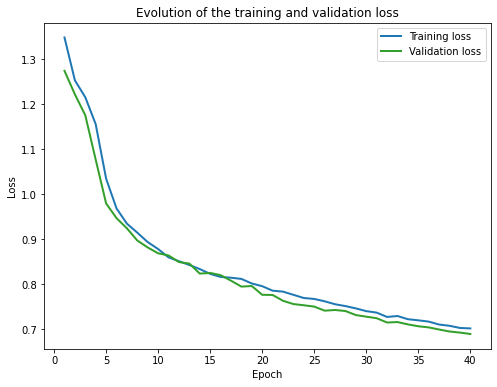

In [18]:
plot_losses(train_history, val_history)

In [25]:
lr = 5e-4
name = '6layerfcn_lr1e-3'

print('\nStart training')
train_history1 = []
val_history1 = []
for epoch in range(20): #TODO decide epochs
    print('-----------------Epoch = %d-----------------' % (epoch+1))
    trainloss = train(train_loader, net, criterion, optimizer, device, epoch+1)
    # TODO create your evaluation set, load the evaluation set and test on evaluation set
    val_loss = test(val_loader, net, criterion, device)

    train_history1.append(trainloss)
    val_history1.append(val_loss)


Start training
-----------------Epoch = 1-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:22,  2.09it/s]

  4%|▍         | 2/48 [00:00<00:20,  2.20it/s]

  6%|▋         | 3/48 [00:01<00:19,  2.28it/s]

  8%|▊         | 4/48 [00:01<00:18,  2.34it/s]

 10%|█         | 5/48 [00:02<00:17,  2.41it/s]

 12%|█▎        | 6/48 [00:02<00:17,  2.43it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.45it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.47it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.49it/s]

 21%|██        | 10/48 [00:04<00:15,  2.48it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.47it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.47it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.49it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.51it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.48it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.46it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.47it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.48it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.48it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 1] loss: 0.626 average_losses: 0.611 elapsed time 19.301




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.62it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.63it/s]

 12%|█▎        | 3/24 [00:01<00:12,  1.62it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.62it/s]

 21%|██        | 5/24 [00:03<00:11,  1.62it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.61it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.61it/s]

 33%|███▎      | 8/24 [00:04<00:10,  1.60it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.60it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.61it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.61it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.61it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.62it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.63it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.62it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.61it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.62it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.61it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.5933188994725546
-----------------Epoch = 2-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:18,  2.57it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.55it/s]

  6%|▋         | 3/48 [00:01<00:17,  2.54it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.52it/s]

 10%|█         | 5/48 [00:02<00:17,  2.48it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.49it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.48it/s]

 17%|█▋        | 8/48 [00:03<00:15,  2.51it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.52it/s]

 21%|██        | 10/48 [00:04<00:15,  2.50it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.49it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.51it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.48it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.48it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.47it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.49it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.52it/s]

 38%|███▊      | 18/48 [00:07<00:11,  2.50it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.50it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 2] loss: 0.622 average_losses: 0.609 elapsed time 19.249




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.57it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.58it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.59it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.61it/s]

 21%|██        | 5/24 [00:03<00:11,  1.60it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.61it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.60it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.60it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.61it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.60it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.61it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.61it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.61it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.61it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.61it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.61it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.61it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.60it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.5892554695407549
-----------------Epoch = 3-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.43it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.45it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.42it/s]

  8%|▊         | 4/48 [00:01<00:18,  2.44it/s]

 10%|█         | 5/48 [00:02<00:17,  2.47it/s]

 12%|█▎        | 6/48 [00:02<00:17,  2.46it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.47it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.45it/s]

 19%|█▉        | 9/48 [00:03<00:16,  2.43it/s]

 21%|██        | 10/48 [00:04<00:15,  2.44it/s]

 23%|██▎       | 11/48 [00:04<00:15,  2.43it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.43it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.44it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.45it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.43it/s]

 33%|███▎      | 16/48 [00:06<00:13,  2.44it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.46it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.45it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.45it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 3] loss: 0.606 average_losses: 0.605 elapsed time 19.591




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.62it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.61it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.61it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.61it/s]

 21%|██        | 5/24 [00:03<00:11,  1.61it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.61it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.61it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.61it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.61it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.60it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.60it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.59it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.58it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.58it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.58it/s]

 67%|██████▋   | 16/24 [00:10<00:05,  1.59it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.60it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.61it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.58it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.5870211149255434
-----------------Epoch = 4-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.45it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.48it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.48it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.48it/s]

 10%|█         | 5/48 [00:02<00:17,  2.48it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.50it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.51it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.50it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.49it/s]

 21%|██        | 10/48 [00:04<00:15,  2.48it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.47it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.48it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.48it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.48it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.48it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.48it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.49it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.49it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.49it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 4] loss: 0.607 average_losses: 0.601 elapsed time 19.349




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.58it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.59it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.59it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.60it/s]

 21%|██        | 5/24 [00:03<00:11,  1.60it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.59it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.60it/s]

 33%|███▎      | 8/24 [00:05<00:10,  1.60it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.60it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.60it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.60it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.58it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.59it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.59it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.60it/s]

 67%|██████▋   | 16/24 [00:10<00:05,  1.60it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.61it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.60it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.60it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.5767271593213081
-----------------Epoch = 5-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:18,  2.49it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.49it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.47it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.49it/s]

 10%|█         | 5/48 [00:02<00:17,  2.48it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.50it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.50it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.49it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.50it/s]

 21%|██        | 10/48 [00:04<00:15,  2.47it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.48it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.48it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.48it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.47it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.46it/s]

 33%|███▎      | 16/48 [00:06<00:13,  2.45it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.46it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.48it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.49it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 5] loss: 0.602 average_losses: 0.592 elapsed time 19.506




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.59it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.59it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.59it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.59it/s]

 21%|██        | 5/24 [00:03<00:12,  1.57it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.58it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.59it/s]

 33%|███▎      | 8/24 [00:05<00:10,  1.59it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.60it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.59it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.60it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.61it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.60it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.61it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.61it/s]

 67%|██████▋   | 16/24 [00:10<00:05,  1.60it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.61it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.60it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.60it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.5852946986754736
-----------------Epoch = 6-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:18,  2.49it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.50it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.49it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.49it/s]

 10%|█         | 5/48 [00:02<00:17,  2.46it/s]

 12%|█▎        | 6/48 [00:02<00:17,  2.47it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.49it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.49it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.49it/s]

 21%|██        | 10/48 [00:04<00:15,  2.49it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.49it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.50it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.49it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.49it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.49it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.49it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.49it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.49it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.48it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 6] loss: 0.608 average_losses: 0.589 elapsed time 19.392




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.56it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.58it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.59it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.60it/s]

 21%|██        | 5/24 [00:03<00:11,  1.59it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.60it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.60it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.61it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.60it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.60it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.60it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.61it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.61it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.61it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.61it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.61it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.62it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.60it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.5729852368434271
-----------------Epoch = 7-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:18,  2.50it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.51it/s]

  6%|▋         | 3/48 [00:01<00:17,  2.50it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.51it/s]

 10%|█         | 5/48 [00:02<00:17,  2.49it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.50it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.50it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.48it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.47it/s]

 21%|██        | 10/48 [00:04<00:15,  2.48it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.48it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.48it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.48it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.46it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.47it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.49it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.48it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.48it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.50it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 7] loss: 0.608 average_losses: 0.588 elapsed time 19.381




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.60it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.59it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.59it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.60it/s]

 21%|██        | 5/24 [00:03<00:11,  1.60it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.61it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.61it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.61it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.61it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.61it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.60it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.60it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.59it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.58it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.59it/s]

 67%|██████▋   | 16/24 [00:10<00:05,  1.58it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.59it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.59it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.59it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.5693751573562622
-----------------Epoch = 8-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.47it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.47it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.49it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.50it/s]

 10%|█         | 5/48 [00:02<00:17,  2.47it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.48it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.50it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.49it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.50it/s]

 21%|██        | 10/48 [00:04<00:15,  2.47it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.49it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.50it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.46it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.46it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.44it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.47it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.47it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.47it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.46it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 8] loss: 0.590 average_losses: 0.584 elapsed time 19.457




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.63it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.63it/s]

 12%|█▎        | 3/24 [00:01<00:12,  1.62it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.62it/s]

 21%|██        | 5/24 [00:03<00:11,  1.61it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.60it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.60it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.60it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.60it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.60it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.60it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.61it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.60it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.61it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.61it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.61it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.61it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.61it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.62it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.5971550171573957
-----------------Epoch = 9-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.43it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.42it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.43it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.45it/s]

 10%|█         | 5/48 [00:02<00:17,  2.47it/s]

 12%|█▎        | 6/48 [00:02<00:17,  2.45it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.47it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.48it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.49it/s]

 21%|██        | 10/48 [00:04<00:15,  2.50it/s]

 23%|██▎       | 11/48 [00:04<00:15,  2.45it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.46it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.47it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.48it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.48it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.48it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.48it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.49it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.50it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 9] loss: 0.590 average_losses: 0.588 elapsed time 19.360




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.61it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.61it/s]

 12%|█▎        | 3/24 [00:01<00:12,  1.62it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.62it/s]

 21%|██        | 5/24 [00:03<00:11,  1.61it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.62it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.61it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.61it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.61it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.61it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.61it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.60it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.61it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.61it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.61it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.61it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.61it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.59it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.566808320581913
-----------------Epoch = 10-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.44it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.45it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.45it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.48it/s]

 10%|█         | 5/48 [00:02<00:17,  2.50it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.49it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.47it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.47it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.47it/s]

 21%|██        | 10/48 [00:04<00:15,  2.48it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.49it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.48it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.47it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.49it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.49it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.50it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.48it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.48it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.48it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 10] loss: 0.591 average_losses: 0.577 elapsed time 19.347




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.62it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.62it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.61it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.62it/s]

 21%|██        | 5/24 [00:03<00:11,  1.61it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.62it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.62it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.62it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.62it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.61it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.61it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.59it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.60it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.60it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.60it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.61it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.61it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.58it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.59it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.5734338189164797
-----------------Epoch = 11-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.47it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.47it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.48it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.49it/s]

 10%|█         | 5/48 [00:02<00:17,  2.49it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.49it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.48it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.44it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.47it/s]

 21%|██        | 10/48 [00:04<00:15,  2.47it/s]

 23%|██▎       | 11/48 [00:04<00:15,  2.45it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.47it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.48it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.49it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.49it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.47it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.49it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.50it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.51it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 11] loss: 0.582 average_losses: 0.576 elapsed time 19.287




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.59it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.60it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.61it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.61it/s]

 21%|██        | 5/24 [00:03<00:11,  1.60it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.60it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.60it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.61it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.60it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.61it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.59it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.59it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.60it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.60it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.60it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.61it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.60it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.61it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.61it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.5753438621759415
-----------------Epoch = 12-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.45it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.45it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.48it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.49it/s]

 10%|█         | 5/48 [00:02<00:17,  2.50it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.51it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.51it/s]

 17%|█▋        | 8/48 [00:03<00:15,  2.51it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.50it/s]

 21%|██        | 10/48 [00:04<00:15,  2.50it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.48it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.47it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.48it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.47it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.42it/s]

 33%|███▎      | 16/48 [00:06<00:13,  2.44it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.45it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.46it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.47it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 12] loss: 0.592 average_losses: 0.574 elapsed time 19.398




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.60it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.60it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.60it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.57it/s]

 21%|██        | 5/24 [00:03<00:12,  1.58it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.59it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.59it/s]

 33%|███▎      | 8/24 [00:05<00:10,  1.60it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.61it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.61it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.61it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.61it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.62it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.61it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.62it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.62it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.62it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.61it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.5621458142995834
-----------------Epoch = 13-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:18,  2.49it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.49it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.49it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.48it/s]

 10%|█         | 5/48 [00:02<00:17,  2.48it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.48it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.49it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.50it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.49it/s]

 21%|██        | 10/48 [00:04<00:15,  2.49it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.48it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.49it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.49it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.49it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.50it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.49it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.49it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.48it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.48it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 13] loss: 0.583 average_losses: 0.572 elapsed time 19.291




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.60it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.61it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.61it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.61it/s]

 21%|██        | 5/24 [00:03<00:11,  1.60it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.59it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.61it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.61it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.60it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.61it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.60it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.60it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.60it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.60it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.60it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.60it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.60it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.61it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.59it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.5551569163799286
-----------------Epoch = 14-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.46it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.46it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.48it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.49it/s]

 10%|█         | 5/48 [00:01<00:17,  2.51it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.51it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.49it/s]

 17%|█▋        | 8/48 [00:03<00:15,  2.51it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.51it/s]

 21%|██        | 10/48 [00:03<00:15,  2.50it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.51it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.49it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.50it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.52it/s]

 31%|███▏      | 15/48 [00:05<00:13,  2.51it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.52it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.51it/s]

 38%|███▊      | 18/48 [00:07<00:11,  2.50it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.50it/s]

 42%|████▏     | 20/48 [00:07<00:11,

[epoch 14] loss: 0.577 average_losses: 0.573 elapsed time 19.276




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.61it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.60it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.60it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.61it/s]

 21%|██        | 5/24 [00:03<00:11,  1.61it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.61it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.61it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.61it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.61it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.61it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.61it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.60it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.59it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.59it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.59it/s]

 67%|██████▋   | 16/24 [00:09<00:05,  1.60it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.60it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.60it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.59it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.5521029010415077
-----------------Epoch = 15-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.46it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.47it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.47it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.47it/s]

 10%|█         | 5/48 [00:02<00:17,  2.47it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.47it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.49it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.48it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.49it/s]

 21%|██        | 10/48 [00:04<00:15,  2.49it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.49it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.50it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.47it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.47it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.47it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.47it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.47it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.47it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.49it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 15] loss: 0.570 average_losses: 0.565 elapsed time 19.328




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.59it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.60it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.61it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.61it/s]

 21%|██        | 5/24 [00:03<00:11,  1.61it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.58it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.59it/s]

 33%|███▎      | 8/24 [00:05<00:10,  1.60it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.60it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.61it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.62it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.62it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.62it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.62it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.62it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.62it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.61it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.62it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.61it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.547984778881073
-----------------Epoch = 16-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:18,  2.49it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.48it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.49it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.49it/s]

 10%|█         | 5/48 [00:02<00:17,  2.48it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.49it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.47it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.47it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.48it/s]

 21%|██        | 10/48 [00:04<00:15,  2.49it/s]

 23%|██▎       | 11/48 [00:04<00:15,  2.45it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.43it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.45it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.48it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.48it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.49it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.48it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.48it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.50it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 16] loss: 0.569 average_losses: 0.562 elapsed time 19.313




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:13,  1.65it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.63it/s]

 12%|█▎        | 3/24 [00:01<00:12,  1.63it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.63it/s]

 21%|██        | 5/24 [00:03<00:11,  1.62it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.61it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.62it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.61it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.62it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.61it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.61it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.62it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.62it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.61it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.62it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.62it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.62it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.60it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.5437216895322005
-----------------Epoch = 17-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.36it/s]

  4%|▍         | 2/48 [00:00<00:19,  2.40it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.42it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.45it/s]

 10%|█         | 5/48 [00:02<00:17,  2.47it/s]

 12%|█▎        | 6/48 [00:02<00:17,  2.44it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.46it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.47it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.50it/s]

 21%|██        | 10/48 [00:04<00:15,  2.50it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.47it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.48it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.47it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.48it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.49it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.48it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.48it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.48it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.46it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 17] loss: 0.572 average_losses: 0.560 elapsed time 19.398




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.59it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.60it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.60it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.60it/s]

 21%|██        | 5/24 [00:03<00:11,  1.61it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.61it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.60it/s]

 33%|███▎      | 8/24 [00:04<00:10,  1.59it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.59it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.60it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.60it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.58it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.59it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.59it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.60it/s]

 67%|██████▋   | 16/24 [00:10<00:04,  1.61it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.60it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.59it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.60it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.555587055782477
-----------------Epoch = 18-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:19,  2.42it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.44it/s]

  6%|▋         | 3/48 [00:01<00:18,  2.45it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.46it/s]

 10%|█         | 5/48 [00:02<00:17,  2.48it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.47it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.48it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.46it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.47it/s]

 21%|██        | 10/48 [00:04<00:15,  2.50it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.49it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.48it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.49it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.50it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.51it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.51it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.49it/s]

 38%|███▊      | 18/48 [00:07<00:11,  2.50it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.52it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 18] loss: 0.571 average_losses: 0.562 elapsed time 19.301




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.62it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.62it/s]

 12%|█▎        | 3/24 [00:01<00:12,  1.62it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.62it/s]

 21%|██        | 5/24 [00:03<00:11,  1.60it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.61it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.61it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.61it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.61it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.60it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.58it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.60it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.60it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.60it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.59it/s]

 67%|██████▋   | 16/24 [00:09<00:05,  1.59it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.60it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.60it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.61it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.551252036044995
-----------------Epoch = 19-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:18,  2.50it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.51it/s]

  6%|▋         | 3/48 [00:01<00:17,  2.50it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.49it/s]

 10%|█         | 5/48 [00:02<00:17,  2.49it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.50it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.50it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.49it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.49it/s]

 21%|██        | 10/48 [00:04<00:15,  2.50it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.48it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.50it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.48it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.48it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.43it/s]

 33%|███▎      | 16/48 [00:06<00:13,  2.43it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.45it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.47it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.47it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 19] loss: 0.570 average_losses: 0.563 elapsed time 19.376




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.59it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.58it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.59it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.56it/s]

 21%|██        | 5/24 [00:03<00:12,  1.58it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.59it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.59it/s]

 33%|███▎      | 8/24 [00:05<00:10,  1.60it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.59it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.60it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.61it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.61it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.62it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.61it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.60it/s]

 67%|██████▋   | 16/24 [00:10<00:04,  1.61it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.61it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.62it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.61it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.5543459579348564
-----------------Epoch = 20-----------------




  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:18,  2.49it/s]

  4%|▍         | 2/48 [00:00<00:18,  2.50it/s]

  6%|▋         | 3/48 [00:01<00:17,  2.50it/s]

  8%|▊         | 4/48 [00:01<00:17,  2.45it/s]

 10%|█         | 5/48 [00:02<00:17,  2.46it/s]

 12%|█▎        | 6/48 [00:02<00:16,  2.48it/s]

 15%|█▍        | 7/48 [00:02<00:16,  2.47it/s]

 17%|█▋        | 8/48 [00:03<00:16,  2.47it/s]

 19%|█▉        | 9/48 [00:03<00:15,  2.46it/s]

 21%|██        | 10/48 [00:04<00:15,  2.48it/s]

 23%|██▎       | 11/48 [00:04<00:14,  2.49it/s]

 25%|██▌       | 12/48 [00:04<00:14,  2.48it/s]

 27%|██▋       | 13/48 [00:05<00:14,  2.48it/s]

 29%|██▉       | 14/48 [00:05<00:13,  2.48it/s]

 31%|███▏      | 15/48 [00:06<00:13,  2.49it/s]

 33%|███▎      | 16/48 [00:06<00:12,  2.49it/s]

 35%|███▌      | 17/48 [00:06<00:12,  2.49it/s]

 38%|███▊      | 18/48 [00:07<00:12,  2.49it/s]

 40%|███▉      | 19/48 [00:07<00:11,  2.48it/s]

 42%|████▏     | 20/48 [00:08<00:11,

[epoch 20] loss: 0.560 average_losses: 0.561 elapsed time 19.397




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:14,  1.60it/s]

  8%|▊         | 2/24 [00:01<00:13,  1.61it/s]

 12%|█▎        | 3/24 [00:01<00:13,  1.60it/s]

 17%|█▋        | 4/24 [00:02<00:12,  1.61it/s]

 21%|██        | 5/24 [00:03<00:11,  1.61it/s]

 25%|██▌       | 6/24 [00:03<00:11,  1.60it/s]

 29%|██▉       | 7/24 [00:04<00:10,  1.61it/s]

 33%|███▎      | 8/24 [00:04<00:09,  1.61it/s]

 38%|███▊      | 9/24 [00:05<00:09,  1.61it/s]

 42%|████▏     | 10/24 [00:06<00:08,  1.62it/s]

 46%|████▌     | 11/24 [00:06<00:08,  1.60it/s]

 50%|█████     | 12/24 [00:07<00:07,  1.61it/s]

 54%|█████▍    | 13/24 [00:08<00:06,  1.61it/s]

 58%|█████▊    | 14/24 [00:08<00:06,  1.61it/s]

 62%|██████▎   | 15/24 [00:09<00:05,  1.62it/s]

 67%|██████▋   | 16/24 [00:09<00:04,  1.62it/s]

 71%|███████   | 17/24 [00:10<00:04,  1.62it/s]

 75%|███████▌  | 18/24 [00:11<00:03,  1.60it/s]

 79%|███████▉  | 19/24 [00:11<00:03,  1.60it/s]

 83%|████████▎ | 20/24 [00:12<00:02,

0.5420738433798155


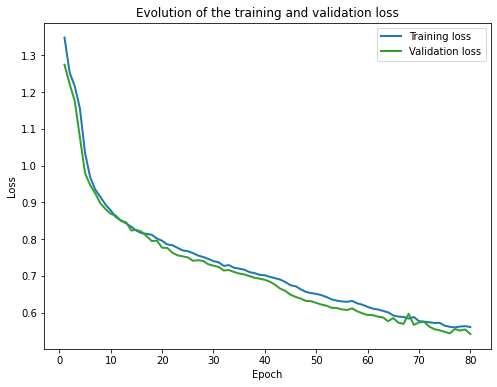

In [26]:
train_history.extend(train_history1)
val_history.extend(val_history1)
plot_losses(train_history, val_history)

In [27]:

torch.save(net.state_dict(), './models/model_{}80.pth'.format(name))

print('\nFinished Training, Testing on test set')
test(test_loader, net, criterion, device)
print('\nGenerating Unlabeled Result')
result = get_result(test_loader, net, device, folder='output_test')

cal_AP(ap_loader, net, criterion, device)


Finished Training, Testing on test set




  0%|          | 0/114 [00:00<?, ?it/s]

  4%|▍         | 5/114 [00:00<00:02, 40.18it/s]

  9%|▉         | 10/114 [00:00<00:02, 41.50it/s]

 13%|█▎        | 15/114 [00:00<00:02, 42.88it/s]

 18%|█▊        | 20/114 [00:00<00:02, 43.86it/s]

 22%|██▏       | 25/114 [00:00<00:01, 44.51it/s]

 26%|██▋       | 30/114 [00:00<00:01, 44.72it/s]

 31%|███       | 35/114 [00:00<00:01, 44.17it/s]

 35%|███▌      | 40/114 [00:00<00:01, 42.81it/s]

 39%|███▉      | 45/114 [00:01<00:01, 43.50it/s]

 44%|████▍     | 50/114 [00:01<00:01, 43.55it/s]

 48%|████▊     | 55/114 [00:01<00:01, 43.88it/s]

 53%|█████▎    | 60/114 [00:01<00:01, 44.58it/s]

 57%|█████▋    | 65/114 [00:01<00:01, 45.13it/s]

 61%|██████▏   | 70/114 [00:01<00:00, 45.56it/s]

 66%|██████▌   | 75/114 [00:01<00:00, 45.77it/s]

 70%|███████   | 80/114 [00:01<00:00, 45.23it/s]

 75%|███████▍  | 85/114 [00:01<00:00, 44.69it/s]

 79%|███████▉  | 90/114 [00:02<00:00, 45.02it/s]

 83%|████████▎ | 95/114 [00:02<00:00, 45.48it/s]

 88%|███

0.7805827589411485

Generating Unlabeled Result




  0%|          | 0/114 [00:00<?, ?it/s]

  1%|          | 1/114 [00:00<00:11,  9.97it/s]

  3%|▎         | 3/114 [00:00<00:10, 10.44it/s]

  4%|▍         | 5/114 [00:00<00:10, 10.75it/s]

  6%|▌         | 7/114 [00:00<00:09, 11.16it/s]

  8%|▊         | 9/114 [00:00<00:09, 11.15it/s]

 10%|▉         | 11/114 [00:00<00:09, 11.31it/s]

 11%|█▏        | 13/114 [00:01<00:08, 11.40it/s]

 13%|█▎        | 15/114 [00:01<00:08, 11.75it/s]

 15%|█▍        | 17/114 [00:01<00:08, 11.72it/s]

 17%|█▋        | 19/114 [00:01<00:07, 11.94it/s]

 18%|█▊        | 21/114 [00:01<00:08, 11.61it/s]

 20%|██        | 23/114 [00:01<00:07, 11.64it/s]

 22%|██▏       | 25/114 [00:02<00:07, 11.61it/s]

 24%|██▎       | 27/114 [00:02<00:07, 12.06it/s]

 25%|██▌       | 29/114 [00:02<00:07, 11.70it/s]

 27%|██▋       | 31/114 [00:02<00:07, 11.72it/s]

 29%|██▉       | 33/114 [00:02<00:07, 11.46it/s]

 31%|███       | 35/114 [00:03<00:06, 11.48it/s]

 32%|███▏      | 37/114 [00:03<00:06, 11.72it/s]

 34%|███▍   

AP = 0.6848866314056524
AP = 0.7915879369475374
AP = 0.22688564635523012
AP = 0.8431800383049156
AP = 0.5737764557783425
Average Ap = 0.6240633417583356


In [0]:
import matplotlib.pyplot as plt

im = plt.imread('my_facade.jpg')
im = (im-127.5) / 127.5
trans = transforms.ToTensor()
im = trans(im).float().to(device)
im = im.view(1, 3, 256, 256)
output = net(im)[0].detach().cpu().numpy()
c, h, w = output.shape
assert(c == N_CLASS)
y = np.zeros((h,w)).astype('uint8')
for i in range(N_CLASS):
    mask = output[i]>0.5
    y[mask] = i
save_label(y, './my_facade_labels.png')

In [28]:
!zip -r output_test.zip ./output_test

  adding: output_test/ (stored 0%)
  adding: output_test/x83.png (deflated 0%)
  adding: output_test/gt16.png (deflated 5%)
  adding: output_test/x101.png (deflated 0%)
  adding: output_test/gt22.png (deflated 10%)
  adding: output_test/x17.png (deflated 0%)
  adding: output_test/y58.png (deflated 1%)
  adding: output_test/gt27.png (deflated 4%)
  adding: output_test/y110.png (deflated 1%)
  adding: output_test/x113.png (deflated 0%)
  adding: output_test/y44.png (deflated 2%)
  adding: output_test/x92.png (deflated 0%)
  adding: output_test/gt78.png (deflated 8%)
  adding: output_test/y75.png (stored 0%)
  adding: output_test/x0.png (deflated 0%)
  adding: output_test/gt93.png (deflated 10%)
  adding: output_test/x90.png (deflated 0%)
  adding: output_test/x107.png (deflated 0%)
  adding: output_test/x6.png (deflated 0%)
  adding: output_test/x69.png (deflated 0%)
  adding: output_test/gt98.png (deflated 12%)
  adding: output_test/gt73.png (deflated 10%)
  adding: output_test/gt10.png

In [0]:
from google.colab import files
files.download('./output_test.zip')
files.download('./models/model_starter_net.pth') 
